In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pip install tweet-preprocessor

In [0]:
pip install nltk

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import preprocessor as p
import os
import re
from tqdm import tqdm
import glob
from collections import Counter
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.externals import joblib
from sklearn.manifold import TSNE

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

from sklearn.manifold import MDS


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
path_kaggle = '/content/gdrive/My Drive/coronawhy/kaggle_twitter_data/'

In [0]:
!ls  '/content/gdrive/My Drive/coronawhy/kaggle_twitter_data/'

sample_submission.csv  test.csv  train.csv


In [0]:
kaggle_data = pd.read_csv(os.path.join(path_kaggle,'train.csv'))

In [0]:
kaggle_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# All emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [0]:
def clean_tweets(tweet):
 
    stop_words = set(stopwords)
    word_tokens = word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
  

In [0]:
kaggle_data['cleaned_text'] = kaggle_data['text'].apply(clean_tweets)

In [0]:
kaggle_data

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked 'shelter place notified of...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby Alaska smoke wildfire...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria_ahrary TheTawniest The control wild fires...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 01:04 UTC 5km S Volcano Hawaii http //t....
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating e-bike collided car Littl...


In [0]:
kaggle_data['target'].unique()

array([1, 0])

In [0]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
kaggle_data['length'] = kaggle_data['cleaned_text'].apply(length)

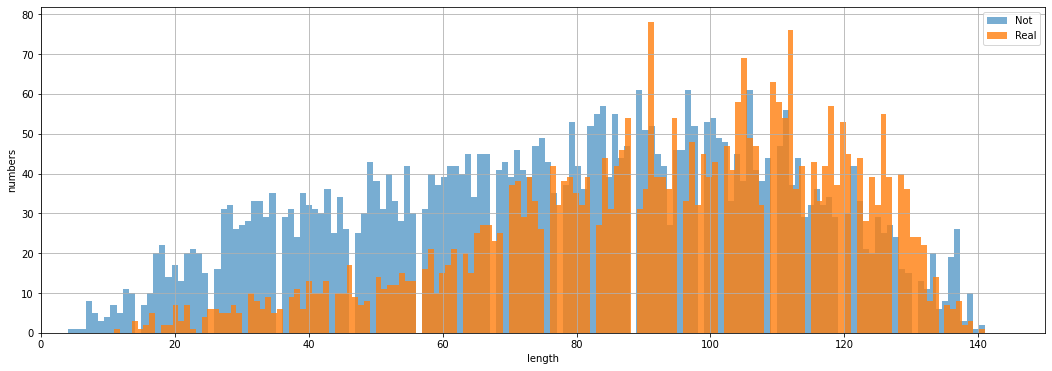

In [0]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(kaggle_data[kaggle_data['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(kaggle_data[kaggle_data['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

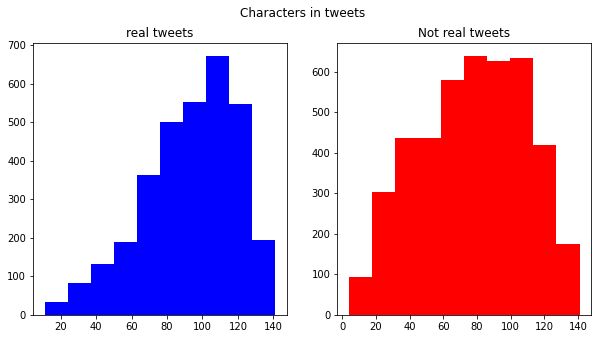

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=kaggle_data[kaggle_data['target']==1]['cleaned_text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('real tweets')
tweet_len=kaggle_data[kaggle_data['target']==0]['cleaned_text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not real tweets')
fig.suptitle('Characters in tweets')
plt.show()

## Number of words in a tweet

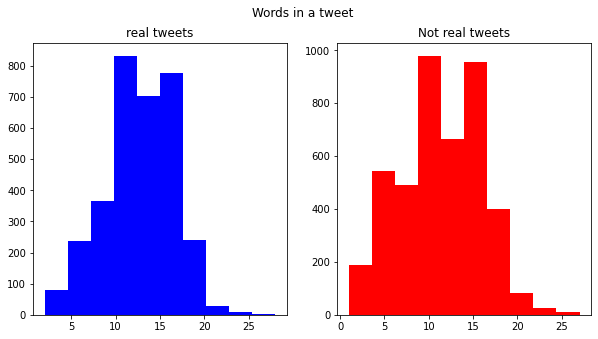

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=kaggle_data[kaggle_data['target']==1]['cleaned_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('real tweets')
tweet_len=kaggle_data[kaggle_data['target']==0]['cleaned_text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not real tweets')
fig.suptitle('Words in a tweet')
plt.show()


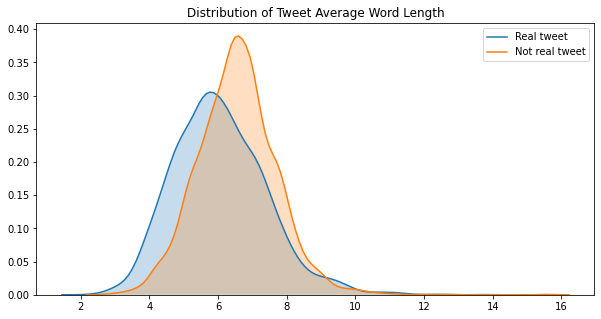

In [0]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
kaggle_data['average word length'] = kaggle_data['cleaned_text'].apply(average_word_length)

#split so we can use updated train set with new feature
#train = total[:len(train)]
train=kaggle_data
#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Real tweet')
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Not real tweet')

#set title
plt.title('Distribution of Tweet Average Word Length')

#splot graphs
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



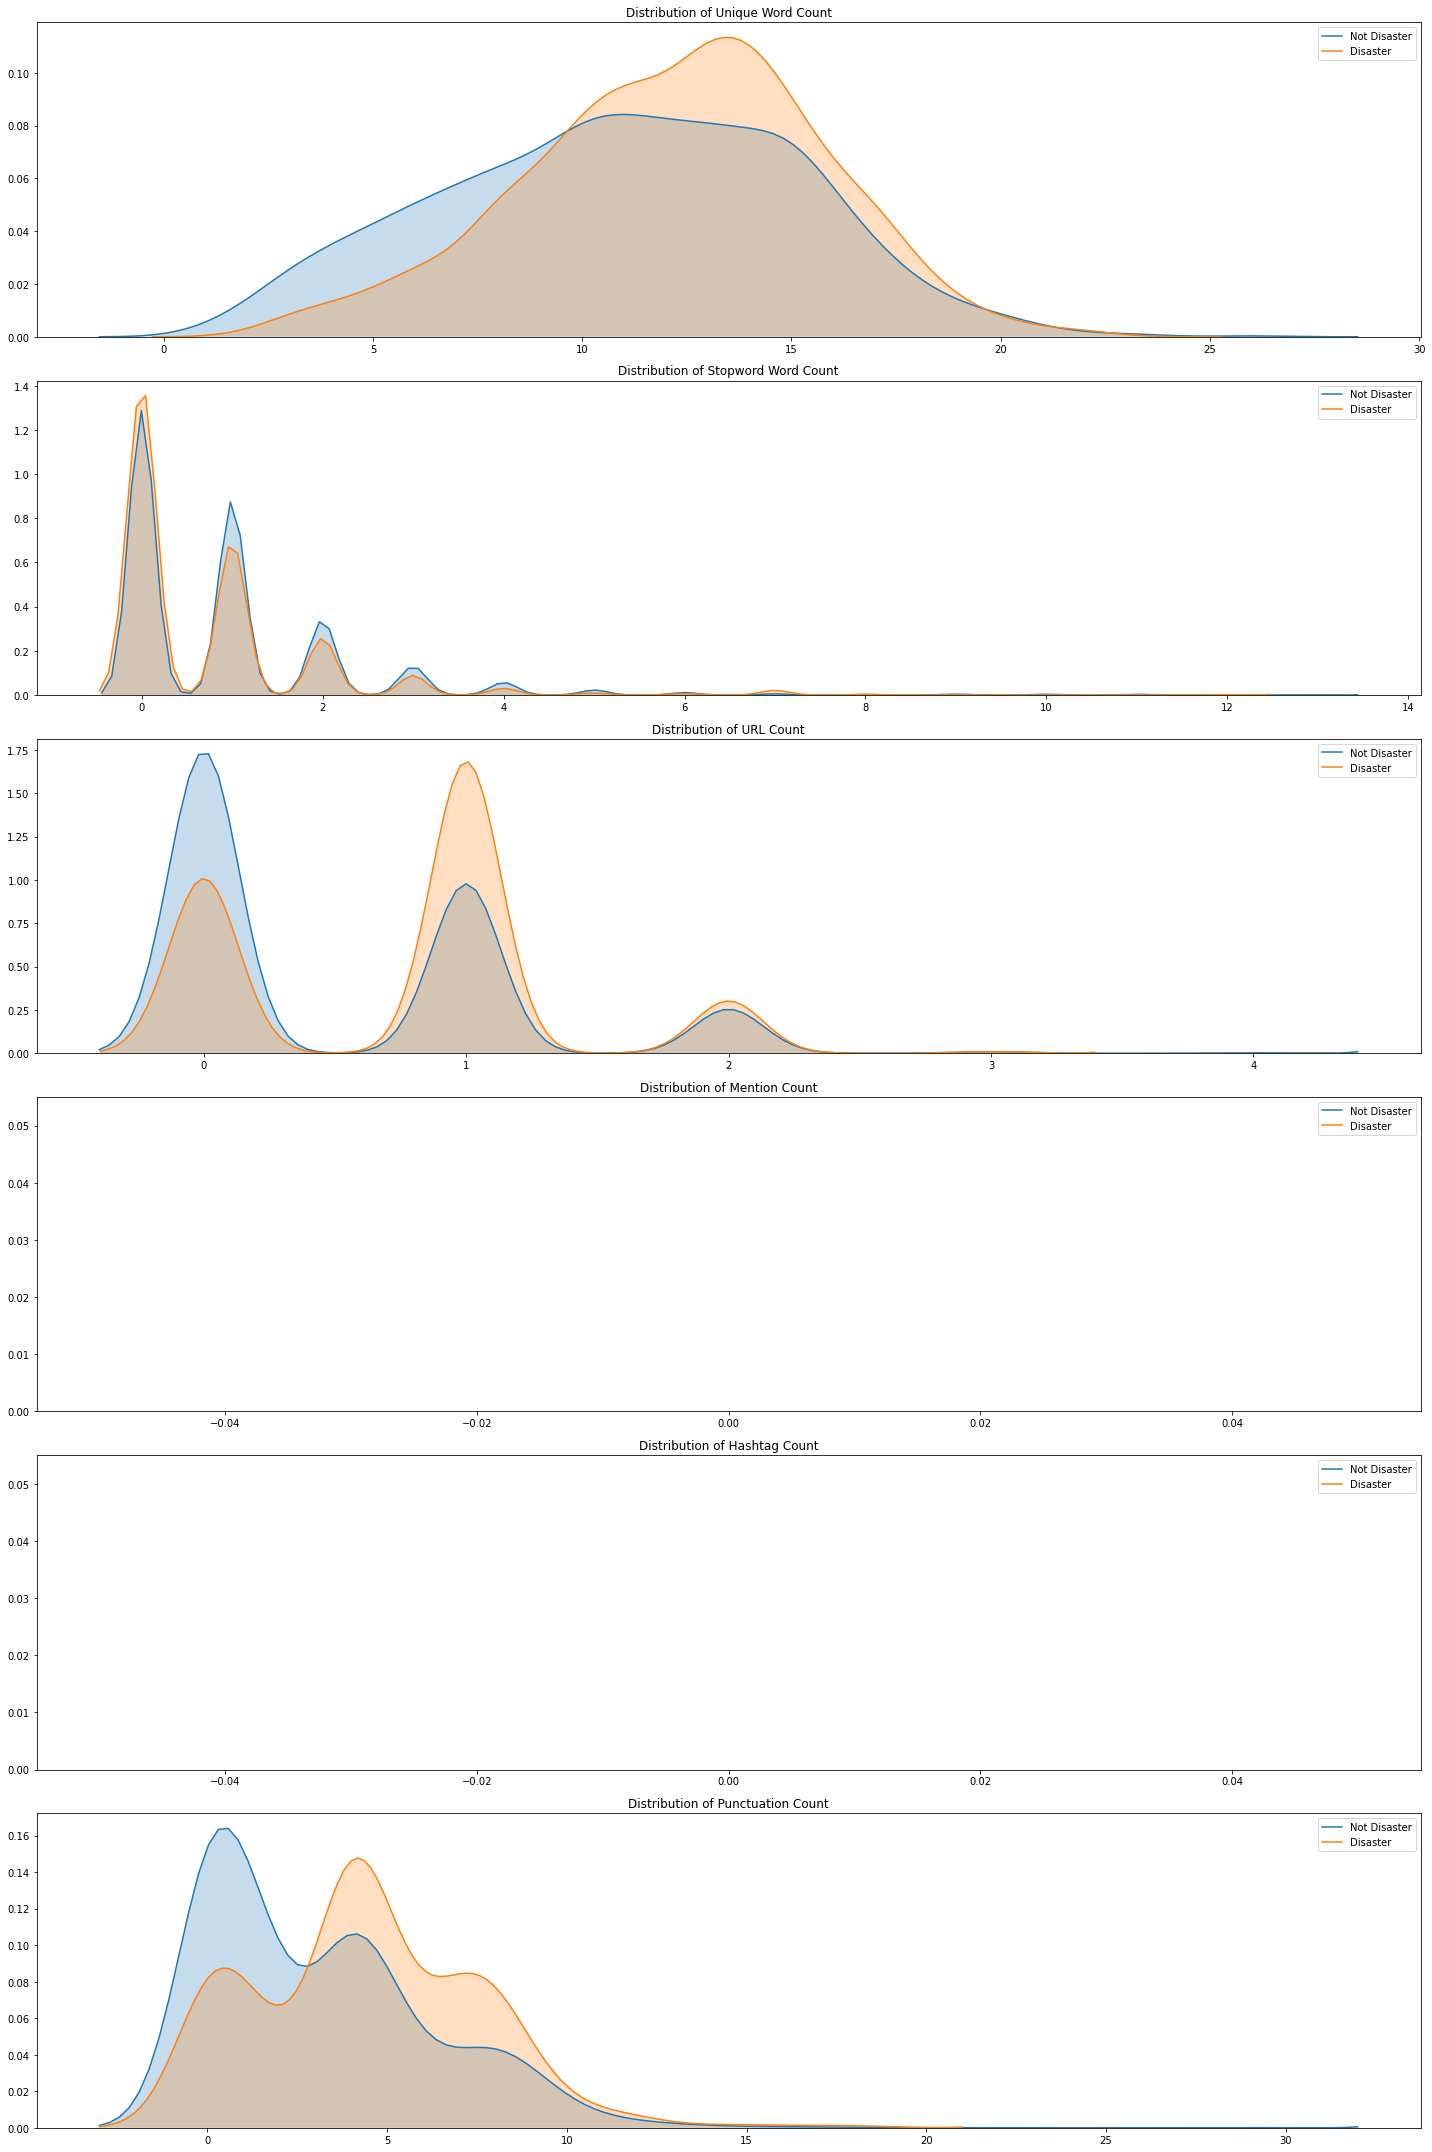

In [0]:
#add unique word count
train['unique word count'] = train['cleaned_text'].apply(lambda x: len(set(x.split())))

#add stopword count
stopwords = stopwords.words('english')
train['stopword count'] = train['cleaned_text'].apply(lambda x: len([i for i in x.lower().split() if i in stopwords]))

#add url count
train['url count'] = train['cleaned_text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
train['mention count'] = train['cleaned_text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
train['hashtag count'] = train['cleaned_text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add punctuation count
train['punctuation count'] = train['cleaned_text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
#train = total[:len(train)]

disaster = train['target'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(6, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train.loc[~disaster]['url count'], shade = True, label = 'Not Disaster', ax=axes[2])
graph3 = sns.kdeplot(train.loc[disaster]['url count'], shade = True, label = 'Disaster', ax=axes[2])
graph3.set_title('Distribution of URL Count')

graph4 = sns.kdeplot(train.loc[~disaster]['mention count'], shade = True,  label = 'Not Disaster', ax=axes[3], bw = 1)
graph4 = sns.kdeplot(train.loc[disaster]['mention count'], shade = True, label = 'Disaster', ax=axes[3], bw =1)
graph4.set_title('Distribution of Mention Count')

graph5 = sns.kdeplot(train.loc[~disaster]['hashtag count'], shade = True, label = 'Not Disaster', ax=axes[4], bw = 1)
graph5 = sns.kdeplot(train.loc[disaster]['hashtag count'], shade = True, label = 'Disaster', ax=axes[4], bw = 1)
graph5.set_title('Distribution of Hashtag Count')

graph6 = sns.kdeplot(train.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[5], bw = 1)
graph6 = sns.kdeplot(train.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[5], bw = 1)
graph6.set_title('Distribution of Punctuation Count')

fig.tight_layout()
plt.show()

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])
train['text_token'] = tokenizer.texts_to_sequences(train['cleaned_text'])

In [0]:
MAX_LENGTH = 2986
X_train_text = tf.keras.preprocessing.sequence.pad_sequences(X_train_text,
                                              maxlen=MAX_LENGTH,
                                              padding='post',
                                              truncating='post')

In [0]:
X_train_text = [tweet for tweet in train['text_token']]
y_train = [label for label in train['target']]

In [0]:
X_train_text

array([[ 641, 4565,  816, ...,    0,    0,    0],
       [ 138,   12,  183, ...,    0,    0,    0],
       [ 132, 1705, 1573, ...,    0,    0,    0],
       ...,
       [2778, 2368,  662, ...,    0,    0,    0],
       [  26, 1093,  532, ...,    0,    0,    0],
       [   6,  161,  103, ...,    0,    0,    0]], dtype=int32)

In [0]:
text_input = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='article_body_input')
text_embed = tf.keras.layers.Embedding(len(tokenizer.index_word)+1, 50, input_length=MAX_LENGTH, name='article_body_embedding')(text_input)
text_conv = tf.keras.layers.Conv1D(256, 10, name='article_body_conv')(text_embed)
text_pool = tf.keras.layers.GlobalMaxPool1D(name='article_body_pooling')(text_conv)
#vector_input = tf.keras.layers.Input(shape=(21,), name='twitter_input')
#concat = tf.keras.layers.concatenate([text_pool, vector_input])
dense_100 = tf.keras.layers.Dense(100, activation='relu')(text_pool)
dense_50 = tf.keras.layers.Dense(50, activation='relu')(dense_100)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_50)
model = tf.keras.models.Model(inputs=text_input, outputs=out_layer)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
article_body_input (InputLay [(None, 2986)]            0         
_________________________________________________________________
article_body_embedding (Embe (None, 2986, 50)          2538500   
_________________________________________________________________
article_body_conv (Conv1D)   (None, 2977, 256)         128256    
_________________________________________________________________
article_body_pooling (Global (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51  

In [0]:
X_train_=np.array([np.array(x) for x in X_train_text])
y_train_ =np.array([np.array(x) for x in y_train])

In [0]:
x =np.asarray(X_train)

In [0]:
y =np.asarray(y_train)

In [0]:
model.fit(x, y)

238/238 [==============================] - 5s 23ms/step - loss: 0.5483 - accuracy: 0.7177


In [0]:
callback = EarlyStopping(monitor = 'val_loss', patience = 5)

In [0]:
!ls '/content/gdrive/My Drive/coronawhy/twitter_data' 

coronavirus-tweet-id-2020-01-21-23.jsonl.gz
coronavirus-tweet-id-2020-05-08-15.jsonl.gz
coronavirus-tweet-id-2020-05-08-17.jsonl.gz
coronavirus-tweet-id-2020-05-08-21.jsonl.gz


In [0]:
os.listdir('/content/gdrive/My Drive/coronawhy/twitter_data/')


['coronavirus-tweet-id-2020-01-21-23.jsonl.gz',
 'coronavirus-tweet-id-2020-05-08-21.jsonl.gz',
 'coronavirus-tweet-id-2020-05-08-17.jsonl.gz',
 'coronavirus-tweet-id-2020-05-08-15.jsonl.gz']

In [0]:
path = '/content/gdrive/My Drive/coronawhy/twitter_data/'
fact_checker_path = '/content/gdrive/My Drive/coronawhy/fact_checker_data/AllTweets_Dec2019_June2020.csv'
first = True

for f in tqdm(os.listdir(path)):
    if(first):
        df = pd.read_json(path + f, compression='gzip', lines=True)
        fact_checker_df = pd.read_csv(fact_checker_path,low_memory= False)
        #first = True
    else:
        df = pd.concat([df, pd.read_json(path + f, compression='gzip', lines=True)])
df = df.loc[df.astype(str).drop_duplicates().index]
df.info()

100%|██████████| 4/4 [00:29<00:00,  7.34s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38462 entries, 0 to 38461
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 38462 non-null  datetime64[ns, UTC]
 1   id                         38462 non-null  int64              
 2   id_str                     38462 non-null  int64              
 3   full_text                  38462 non-null  object             
 4   truncated                  38462 non-null  bool               
 5   display_text_range         38462 non-null  object             
 6   entities                   38462 non-null  object             
 7   extended_entities          3152 non-null   object             
 8   source                     38462 non-null  object             
 9   in_reply_to_status_id      2790 non-null   float64            
 10  in_reply_to_status_id_str  2790 non-null   float64            
 11  in

## Data Preprocessing
### Getting all the list of emoticons and other pictorials first.

In [0]:
# Cleaning all the tweets
%%time
# Cleaning using tweet-preprocessor tool first
df['full_text'] = [p.clean(x) for x in df['full_text']]

# Performing some extra custom cleaning steps
df['full_text'] = [clean_tweets(x) for x in df['full_text']]

# Performing cleaning too fact-checking tweets
fact_checker_df['tweet'] = [p.clean(x) for x in fact_checker_df['tweet']]
fact_checker_df['tweet'] = [clean_tweets(x) for x in fact_checker_df['tweet']]

CPU times: user 38.5 s, sys: 17.2 ms, total: 38.6 s
Wall time: 38.6 s


In [0]:
df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries,withheld_scope
0,2020-05-08 15:00:00+00:00,1258773653350608896,1258773653350608896,Today last day take part survey PLEASE TAKE PA...,False,"[0, 261]","{'hashtags': [{'text': 'marketsmatter', 'indic...","{'media': [{'id': 1258358131807129602, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 242151266, 'id_str': '242151266', 'name...",None,None,None,NaN,False,2,0,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-08 15:00:00+00:00,1258773653497544704,1258773653497544704,En te invitamos tomar las medidas necesarias p...,False,"[0, 240]","{'hashtags': [{'text': 'Covid_19', 'indices': ...","{'media': [{'id': 1257644553848356869, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 444002414, 'id_str': '444002414', 'name...",None,None,None,NaN,False,10,8,False,False,0.0,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-08 15:00:00+00:00,1258773653531111427,1258773653531111424,With dynamic interactive method learning cours...,False,"[0, 271]","{'hashtags': [{'text': 'CDVDM', 'indices': [72...","{'media': [{'id': 1258065503718801408, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 20024805, 'id_str': '20024805', 'name':...",None,None,None,NaN,False,0,0,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-08 15:00:00+00:00,1258773653673705472,1258773653673705472,El en el Congreso de Yucatn present un exhorto...,False,"[0, 238]","{'hashtags': [{'text': 'PAN', 'indices': [3, 7...","{'media': [{'id': 1255631671912804357, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 2680651274, 'id_str': '2680651274', 'na...",None,None,None,NaN,False,0,1,False,False,0.0,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-08 15:00:00+00:00,1258773653849812992,1258773653849812992,Thank much awesome support This edition Learn ...,False,"[0, 140]","{'hashtags': [{'text': 'thankyou', 'indices': ...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 99767557, 'id_str': '99767557', 'name':...",None,None,None,NaN,True,10,0,False,False,NaN,en,{'created_at': 'Thu May 07 17:57:34 +0000 2020...,1.258453e+18,1.258453e+18,"{'url': 'https://t.co/7JmFX2a46G', 'expanded':...",NaN,NaN,NaN


## Preprocessing Twitter data
### First, we transform textual data into vectors based on tf-idf algorithm.

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['full_text'])
df['text_token'] = tokenizer.texts_to_sequences(df['full_text'])
X_test_text = [tweet for tweet in df['text_token']]


In [0]:
X_test_text = tf.keras.preprocessing.sequence.pad_sequences(X_test_text,
                                              maxlen=MAX_LENGTH,
                                              padding='post',
                                              truncating='post')

In [0]:
x_test=np.asarray(X_test_text)

In [0]:
x_test

array([[   39,   300,    73, ...,     0,     0,     0],
       [    8,   272,  9281, ...,     0,     0,     0],
       [  375, 12738,  6707, ...,     0,     0,     0],
       ...,
       [18243,     2,  1633, ...,     0,     0,     0],
       [ 8371, 13008,   440, ...,     0,     0,     0],
       [ 5073,    50,     1, ...,     0,     0,     0]], dtype=int32)

In [0]:
model.predict(x_test)

array([[0.5767108 ],
       [0.31887648],
       [0.32003942],
       ...,
       [0.7276093 ],
       [0.2537726 ],
       [0.5230926 ]], dtype=float32)